In [1]:
'''Imports'''
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

import torchvision
import torchvision.transforms as transforms

import os
import argparse

from models import resnet
from utils import progress_bar

In [2]:
import time
import copy

In [3]:
torch.manual_seed(43)

# Environment Variables
best_acc = 0  # best test accuracy
epochs = 15  # start from epoch 0 or last checkpoint epoch
lr = 0.1


In [4]:
epochs = 15

In [5]:
# Test That GPU is available
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

GeForce RTX 2070 with Max-Q Design
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [6]:
#  Transforms
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

==> Preparing data..


In [7]:
# Download Dataset
dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform_train)

# Download Test Dataset
testset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
val_size = 5000
train_size = len(dataset) - val_size

In [9]:
# Train Loaders

# Split Dataset to Train/Validate
trainset, validset = random_split(dataset, [train_size, val_size])
len(trainset), len(validset)

# Train Loader
trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=128, shuffle=True, num_workers=8)

# Valid Loader
validloader = torch.utils.data.DataLoader(
    validset, batch_size=128, shuffle=True, num_workers=8)

# Test Loader
testloader = torch.utils.data.DataLoader(
    testset, batch_size=100, shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck')

In [10]:
# Split Dataset into Training

# Helper Functions

In [11]:
# Load Original Model
def create_model():
    net = resnet.ResNet18()
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=0)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
    
    return net, criterion, optimizer, scheduler

In [25]:
def accuracy(outputs):
    print(classes)
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == classess).item() / len(preds))

def training_step(batch):
    images, labels = batch 
    out = self(images)                  # Generate predictions
    loss = F.cross_entropy(out, labels) # Calculate loss
    return loss
    
def validation_step(batch):
    images, labels = batch 
    out = self(images)                    # Generate predictions
    loss = F.cross_entropy(out, classes)   # Calculate loss
    acc = accuracy(out, labels)           # Calculate accuracy
    return {'val_loss': loss, 'val_acc': acc}
        
def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
def epoch_end(epoch, result):
    print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))
    
def test_end(result):
    print("Test Set:, val_loss: {:.4f}, val_acc: {:.4f}".format(result['val_loss'], result['val_acc']))

def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [13]:
# Train
def train(model, epoch, train_loader, criterion, optimizer):
    print('Training Step: Epoch: {}'.format(epoch))
    model.train()
    train_loss = 0
    correct = 0
    total = 0
        
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        #train_loss += loss.item()
        #_, predicted = outputs.max(1)
        #total += targets.size(0)
        #correct += predicted.eq(targets).sum().item()

        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
        #             % (train_loss/(batch_idx+1), 100.*correct/total, correct, total))
        

In [14]:
# Train
def validate(model, epoch, valid_loader, criterion, optimizer):
    print('Validation Step: Epoch: {}'.format(epoch))
    model.eval()
    train_loss = 0
    correct = 0
    total = 0
    stat_outputs = []
    
    
    for batch_idx, (inputs, labels) in enumerate(valid_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # Generate Loss
        loss = F.cross_entropy(outputs, labels)

        #train_loss += loss.item()
        # Generate Accuracy
        _, preds = outputs.max(1)
        acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        
        # Add To Results
        stat_outputs.append({'epoch': epoch, 'val_loss': loss, 'val_acc': acc})
        
        #total += targets.size(0)
        #correct += predicted.eq(targets).sum().item()
        #stat_outputs.append({'val_loss': train_loss/(batch_idx+1), 'val_acc': 100.*correct/total})
        #progress_bar(batch_idx, len(trainloader), 'Loss: %.3f | Acc: %.3f%% (%d/%d)' % (loss, acc, correct, total))
        
    result = validation_epoch_end(stat_outputs)
    result['epoch'] = epoch
    
    epoch_end(epoch, result)
    return result
    #print(result)

In [26]:
# Test
def test(model, test_loader, criterion, optimizer):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    stat_outputs = []
    
    with torch.no_grad():
        for batch_idx, (inputs, labels) in enumerate(test_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, preds = outputs.max(1)

            # Generate Loss
            loss = F.cross_entropy(outputs, labels)

            #train_loss += loss.item()
            # Generate Accuracy
            _, preds = outputs.max(1)
            acc = torch.tensor(torch.sum(preds == labels).item() / len(preds))
        
            # Add To Results
            stat_outputs.append({'val_loss': loss, 'val_acc': acc})
            
    result = validation_epoch_end(stat_outputs)
    test_end(result)
    return result
 

In [16]:
run_group_dict_template = {
    'run_name': '',
    'run_description': '',
    'training_group': []
}

run_dict_template = {
    'train_size': 0,
    'validation_size': 0,
    'test_size': 0,
    'time_to_train_validate': 0,
    'validation_step_results': [],
    'test_result': {}
    }

In [17]:
new_model, criterion, optimizer, scheduler = create_model()

In [ ]:
run_dicts = []
new_run_group_dict = copy.deepcopy(run_group_dict_template)
new_run_dict = copy.deepcopy(run_dict_template)
new_run_group_dict['run_name'] = 'TrainAll'
new_run_group_dict['run_description'] = "All Data - 90/10 train/validate split"
start_time = time.time()
for epoch in range(0, 15):
    new_run_dict['train_size'] = len(trainloader.dataset)
    new_run_dict['validation_size'] = len(validloader.dataset)
    train(new_model, epoch, trainloader, criterion, optimizer)
    new_run_dict['validation_step_results'].append(validate(new_model, epoch, validloader, criterion, optimizer))
    scheduler.step()
    
new_run_dict['time_to_train_validate'] = int(time.time() - start_time)

new_run_dict['test_result'] = test(new_model, testloader, criterion, optimizer)

new_run_group_dict['training_group'].append(new_run_dict)

In [ ]:
import json
print(json.dumps(new_run_group_dict, indent=4))

# Grouping Training Section

In [18]:
test_run_labels = ['small', 'medium', 'large', 'all']
test_run_increment_sizes = [1000, 5000, 10000, len(dataset)]

print(test_run_labels)
print(test_run_increment_sizes)

['small', 'medium', 'large', 'all']
[1000, 5000, 10000, 50000]


In [19]:
model_group_results_arr = []

In [ ]:
run_number = 1

In [ ]:
#for x in range(0, len(test_run_labels)):
for x in range(0, len(test_run_labels)):
    label = test_run_labels[x]
    increment_size = test_run_increment_sizes[x]
    
    new_run_group_dict = copy.deepcopy(run_group_dict_template)
    new_run_group_dict['run_name'] = 'Train-label: {}'.format(label)
    new_run_group_dict['run_description'] = "Training/Testing on Increment Size: {}".format(increment_size)
    
    file_name_run = 'data_' + label + '_' + str(run_number) + '_run.txt'
    file_name_group = 'data_' + label + '_' + str(run_number) + '_group.txt'
    f_run = open(file_name_run, 'w')
    f_group = open(file_name_group, 'w')
    
    print('Incrementing Group: {}, increment_size: {}'.format(label, increment_size))
    
    # Each one has an initial 1000 to train off of
    for ds_size in range(10000, len(dataset) + 10000, increment_size):
        print('----------------------------------------------')
        increment_model = create_model()
        
        new_run_dict = copy.deepcopy(run_dict_template)
        
        # Make sure that in range includes the max size for each dataset
        if (ds_size >= len(dataset)) and (ds_size <= len(dataset) + increment_size):
            ds_size = 50000
        elif ds_size <= len(dataset):
            pass
        else:
            break
        
        # Creating our Torch Datasets
        print("Dataset Size: {}".format(ds_size))
        increment_dataset = torch.utils.data.Subset(dataset, list(range(0, ds_size)))
        if ds_size == len(dataset):
            print('Utilizing Test Set')
            test_dataset = testset
        elif ds_size + increment_size > len(dataset):
            print('Taking The Rest of Data as Test Set')
            test_dataset = torch.utils.data.Subset(dataset, list(range(ds_size, len(dataset))))
        else:
            print('Taking Next Increment of Data as Test Set')
            test_dataset = torch.utils.data.Subset(dataset, list(range(ds_size, ds_size + increment_size)))
        
            
        print(len(test_dataset))
            
        # Split train/val on Dataset
        val_size = int(len(increment_dataset) * .1)
        train_size = int(len(increment_dataset) - val_size)
        
        print('train: {}, val: {}, dataset: {}'.format(train_size, val_size, len(increment_dataset)))
        
        # Split Dataset to Train/Validate
        increment_trainset = torch.utils.data.Subset(increment_dataset, list(range(0, train_size)))
        increment_validset = torch.utils.data.Subset(increment_dataset, list(range(train_size, len(increment_dataset))))
        
        print('Dataset Sizes: train: {}, val: {}, dataset: {}'.format(len(increment_trainset), len(increment_validset), len(increment_dataset)))

        # Create Train Loader
        increment_trainloader = torch.utils.data.DataLoader(
            increment_trainset, batch_size=128, shuffle=True, num_workers=2)
        
        # Valid Loader
        increment_validloader = torch.utils.data.DataLoader(
            increment_validset, batch_size=128, shuffle=True, num_workers=2)
        
        # Download Test Dataset & Get Test Loader
        increment_testloader = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)
        
        increment_model, criterion, optimizer, scheduler = create_model()
        
        new_run_dict['train_size'] = len(increment_trainloader.dataset)
        new_run_dict['validation_size'] = len(increment_validloader.dataset)
        
        start_time = time.time()
        
        for epoch in range(0, epochs):
            train(increment_model, epoch, increment_trainloader, criterion, optimizer)
            valid_results = validate(increment_model, epoch, increment_validloader, criterion, optimizer)
            new_run_dict['validation_step_results'].append(valid_results)
            scheduler.step()
        
        new_run_dict['time_to_train_validate'] = int(time.time() - start_time)
        new_run_dict['test_result'] = test(increment_model, increment_testloader, criterion, optimizer)
        new_run_group_dict['training_group'].append(new_run_dict)
        
        f_run.write(json.dumps(new_run_dict) + '\n')
    
    json.dump(new_run_group_dict, f_group)

    model_group_results_arr.append(new_run_group_dict)
    
    f_run.close()
    f_group.close()

In [ ]:
#f_run.close()
#f_group.close()

In [ ]:
#print(json.dumps(model_group_results_arr, indent=4))

# Drift Calculation Section

In [20]:
accuracy_threshold = .5
drift_run_number = 0

In [21]:
def train_model(dataset):
    # Split train/val on Dataset
    val_size = int(len(dataset) * .1)
    train_size = int(len(dataset) - val_size)
    print('train: {}, val: {}, dataset: {}'.format(train_size, val_size, len(dataset)))

    
    # Split Dataset to Train/Validate
    increment_trainset = torch.utils.data.Subset(
        dataset, list(range(0, train_size)))
    increment_validset = torch.utils.data.Subset(
        dataset, list(range(train_size, len(dataset))))
    
    print('Dataset Sizes: train: {}, val: {}, dataset: {}'.format(len(increment_trainset), len(increment_validset), len(dataset)))

    
    # Create Train Loader
    increment_trainloader = torch.utils.data.DataLoader(
        increment_trainset, batch_size=128, shuffle=True, num_workers=12)
        
    # Valid Loader
    increment_validloader = torch.utils.data.DataLoader(
        increment_validset, batch_size=128, shuffle=True, num_workers=12)
    
    increment_model, criterion, optimizer, scheduler = create_model()
    start_time = time.time()
    
    new_run_dict = copy.deepcopy(run_dict_template)
    new_run_dict['train_size'] = len(increment_trainloader.dataset)
    new_run_dict['validation_size'] = len(increment_validloader.dataset)
    
    for epoch in range(0, epochs):
        train(increment_model, epoch, increment_trainloader, criterion, optimizer)
        valid_results = validate(increment_model, epoch, increment_validloader, criterion, optimizer)
        new_run_dict['validation_step_results'].append(valid_results)
        scheduler.step()
        
    new_run_dict['time_to_train_validate'] = int(time.time() - start_time)
    
    return increment_model, new_run_dict, criterion, optimizer
        

In [30]:
import json
#for x in range(0, len(test_run_labels)):
for x in range(0, len(test_run_labels)):
    label = test_run_labels[x]
    increment_size = test_run_increment_sizes[x]
    
    new_run_group_dict = copy.deepcopy(run_group_dict_template)
    new_run_group_dict['run_name'] = 'Train-label: {}'.format(label)
    new_run_group_dict['run_description'] = "Training/Testing on Drift Increment Size: {}".format(increment_size)
    
    file_name_run = 'data_' + label + '_' + str(drift_run_number) + '_run_drift.txt'
    file_name_group = 'data_' + label + '_' + str(drift_run_number) + '_group_drift.txt'
    f_run = open(file_name_run, 'w')
    f_group = open(file_name_group, 'w')
    
    print('Incrementing Group: {}, increment_size: {}'.format(label, increment_size))
    
    # Dataset for the images that were above the threshold
    # They'll be added to the increment_dataset once accuracy is to low
    retrain = False
    
    # Create Initial Trained Model
    increment_model, new_run_dict,  criterion, optimizer = train_model(torch.utils.data.Subset(dataset, list(range(0, 10000))))
    new_run_dict['test_result'] = []
    
    # Each one has an initial 1000 to train off of
    for ds_size in range(10000, len(dataset) + 10000, increment_size):
        print('----------------------------------------------')
        
        # Make sure that in range includes the max size for each dataset
        if (ds_size >= len(dataset)) and (ds_size <= len(dataset) + increment_size):
            ds_size = 50000
        elif ds_size <= len(dataset):
            pass
        else:
            break
        
        # Creating Training Dataset and New models
        if retrain:
            print("Retraining Model")
            increment_dataset = torch.utils.data.Subset(dataset, list(range(0, ds_size)))
            increment_model, new_run_dict,  criterion, optimizer = train_model(increment_dataset)
            new_run_dict['test_result'] = []
            retrain = False
        
        # Creating our Test Datasets
        if ds_size == len(dataset):
            print('Utilizing Test Set')
            test_dataset = testset
        elif ds_size + increment_size > len(dataset):
            print('Taking The Rest of Data as Test Set')
            test_dataset = torch.utils.data.Subset(dataset, list(range(ds_size, len(dataset))))
        else:
            print('Taking Next Increment of Data as Test Set')
            test_dataset = torch.utils.data.Subset(dataset, list(range(ds_size, ds_size + increment_size)))
        
            
        print(len(test_dataset))
            
        # Download Test Dataset & Get Test Loader
        increment_testloader = torch.utils.data.DataLoader(
            test_dataset, batch_size=100, shuffle=False, num_workers=12)
        
        test_results = test(increment_model, increment_testloader, criterion, optimizer)
        new_run_dict['test_result'].append(test_results)
        new_run_group_dict['training_group'].append(new_run_dict)
        
        if(test_results['val_acc'] < accuracy_threshold):
            f_run.write(json.dumps(new_run_dict) + '\n')
            retrain = True
        else:
            print('Retraining Not Needed: {}'.format(test_results))
        
       
    
    json.dump(new_run_group_dict, f_group)

    model_group_results_arr.append(new_run_group_dict)
    
    f_run.close()
    f_group.close()

Incrementing Group: small, increment_size: 1000
train: 9000, val: 1000, dataset: 10000
Dataset Sizes: train: 9000, val: 1000, dataset: 10000
Training Step: Epoch: 0
Validation Step: Epoch: 0
Epoch [0], val_loss: 2.0333, val_acc: 0.2172
Training Step: Epoch: 1
Validation Step: Epoch: 1
Epoch [1], val_loss: 4.3359, val_acc: 0.1415
Training Step: Epoch: 2
Validation Step: Epoch: 2
Epoch [2], val_loss: 1.9720, val_acc: 0.2373
Training Step: Epoch: 3
Validation Step: Epoch: 3
Epoch [3], val_loss: 1.8624, val_acc: 0.2626
Training Step: Epoch: 4
Validation Step: Epoch: 4
Epoch [4], val_loss: 1.7854, val_acc: 0.3253
Training Step: Epoch: 5
Validation Step: Epoch: 5
Epoch [5], val_loss: 1.7802, val_acc: 0.3296
Training Step: Epoch: 6
Validation Step: Epoch: 6
Epoch [6], val_loss: 1.8503, val_acc: 0.3222
Training Step: Epoch: 7
Validation Step: Epoch: 7
Epoch [7], val_loss: 1.7821, val_acc: 0.3354
Training Step: Epoch: 8
Validation Step: Epoch: 8
Epoch [8], val_loss: 1.6778, val_acc: 0.3694
Trai

Epoch [8], val_loss: 1.5488, val_acc: 0.4435
Training Step: Epoch: 9
Validation Step: Epoch: 9
Epoch [9], val_loss: 1.5064, val_acc: 0.4555
Training Step: Epoch: 10
Validation Step: Epoch: 10
Epoch [10], val_loss: 1.3870, val_acc: 0.4958
Training Step: Epoch: 11
Validation Step: Epoch: 11
Epoch [11], val_loss: 1.3427, val_acc: 0.5156
Training Step: Epoch: 12
Validation Step: Epoch: 12
Epoch [12], val_loss: 1.3290, val_acc: 0.5210
Training Step: Epoch: 13
Validation Step: Epoch: 13
Epoch [13], val_loss: 1.2555, val_acc: 0.5547
Training Step: Epoch: 14
Validation Step: Epoch: 14
Epoch [14], val_loss: 1.2321, val_acc: 0.5685
Taking Next Increment of Data as Test Set
1000
Test Set:, val_loss: 1.1530, val_acc: 0.5830
Retraining Not Needed: {'val_loss': 1.153031587600708, 'val_acc': 0.5830000042915344}
----------------------------------------------
Taking Next Increment of Data as Test Set
1000
Test Set:, val_loss: 1.1384, val_acc: 0.6000
Retraining Not Needed: {'val_loss': 1.138388276100158

Test Set:, val_loss: 1.1592, val_acc: 0.5913
Retraining Not Needed: {'val_loss': 1.159196138381958, 'val_acc': 0.5912999510765076}
----------------------------------------------
Utilizing Test Set
10000
Test Set:, val_loss: 1.1592, val_acc: 0.5913
Retraining Not Needed: {'val_loss': 1.159196138381958, 'val_acc': 0.5912999510765076}
----------------------------------------------
Incrementing Group: medium, increment_size: 5000
train: 9000, val: 1000, dataset: 10000
Dataset Sizes: train: 9000, val: 1000, dataset: 10000
Training Step: Epoch: 0
Validation Step: Epoch: 0
Epoch [0], val_loss: 2.1643, val_acc: 0.1690
Training Step: Epoch: 1
Validation Step: Epoch: 1
Epoch [1], val_loss: 2.5339, val_acc: 0.1412
Training Step: Epoch: 2
Validation Step: Epoch: 2
Epoch [2], val_loss: 2.0121, val_acc: 0.2218
Training Step: Epoch: 3
Validation Step: Epoch: 3
Epoch [3], val_loss: 2.1885, val_acc: 0.2077
Training Step: Epoch: 4
Validation Step: Epoch: 4
Epoch [4], val_loss: 1.9213, val_acc: 0.2822
Tr

Epoch [2], val_loss: 1.5881, val_acc: 0.4214
Training Step: Epoch: 3
Validation Step: Epoch: 3
Epoch [3], val_loss: 1.6915, val_acc: 0.4038
Training Step: Epoch: 4
Validation Step: Epoch: 4
Epoch [4], val_loss: 1.5704, val_acc: 0.4434
Training Step: Epoch: 5
Validation Step: Epoch: 5
Epoch [5], val_loss: 1.2862, val_acc: 0.5488
Training Step: Epoch: 6
Validation Step: Epoch: 6
Epoch [6], val_loss: 1.1376, val_acc: 0.5986
Training Step: Epoch: 7
Validation Step: Epoch: 7
Epoch [7], val_loss: 0.9856, val_acc: 0.6594
Training Step: Epoch: 8
Validation Step: Epoch: 8
Epoch [8], val_loss: 1.3967, val_acc: 0.5098
Training Step: Epoch: 9
Validation Step: Epoch: 9
Epoch [9], val_loss: 0.8803, val_acc: 0.6982
Training Step: Epoch: 10
Validation Step: Epoch: 10
Epoch [10], val_loss: 0.7408, val_acc: 0.7432
Training Step: Epoch: 11
Validation Step: Epoch: 11
Epoch [11], val_loss: 0.7351, val_acc: 0.7427
Training Step: Epoch: 12
Validation Step: Epoch: 12
Epoch [12], val_loss: 0.6474, val_acc: 0.7

In [29]:
f_run.close()
f_group.close()

# Graphing Grouping Analysis

In [42]:
import matplotlib.pyplot as plt
import json

In [117]:
def plot_accuracies(history, title='Accuracy vs. Total Training Time'):
    accuracies = [x['val_acc'] for x in history]
    total_times = [x['total_time'] for x in history]
    plt.plot(total_times, accuracies)
    plt.xlabel('total time (min)')
    plt.ylabel('accuracy')
    plt.title(title);
    plt.show()
    
def plot_accuracies_multi(histories, title):
    for history in histories:
        accuracies = [x['val_acc'] for x in history['graph_data']]
        total_times = [x['total_time'] for x in history['graph_data']]
        plt.plot(total_times, accuracies, label=history['line_title'])
    
    plt.xlabel('total time (min)')
    plt.ylabel('accuracy')
    plt.title(title)
    plt.legend()
    plt.show()
    
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('total_time')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');
    
def plot_bar(x, y, x_label, y_label, title):
    print(x)
    print(y)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(x, y)
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    plt.show()

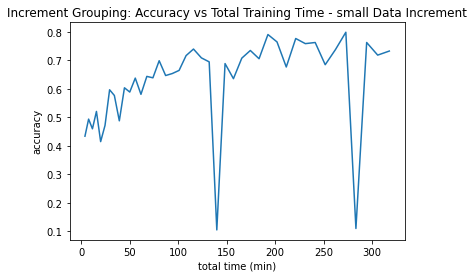

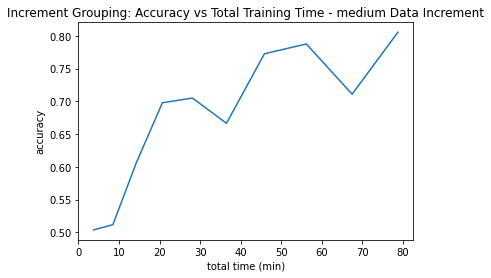

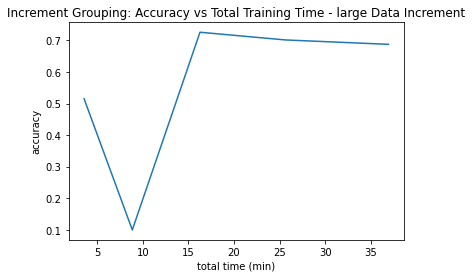

In [138]:
# Load in Data File for Groupings Run
file_names = ['data_small_1_group.txt', 'data_medium_1_group.txt', 'data_large_1_group.txt']
comparison_arr = []
avg_accuracy_arr = []
training_times_arr = []
x_label_names = []
for file_name in file_names:
    with open('result_data/run_2_weight_decay_1e_1/' + file_name, 'r') as f:
        run_group_dict = json.load(f)
        x_label_names.append(run_group_dict['run_name'].split(' ')[1])
    
        graph_data = []
        total_training_time = 0
        for group in run_group_dict['training_group']:
            group_test_dict = group['test_result']
            total_training_time += group['time_to_train_validate']
            group_test_dict['total_time'] = total_training_time/60
            graph_data.append(group_test_dict)
            
        # Get Total Training Time in Minutes
        training_times_arr.append(total_training_time/60)
        
        # Get Avg Accuracy    
        avg_accuracy = sum([x['val_acc'] for x in graph_data]) / len(graph_data)
        avg_accuracy_arr.append(avg_accuracy)
        
        # Build Line Graph Comparison Dict
        comparison_arr_dict = {
            'line_title': run_group_dict['run_name'],
            'graph_data': graph_data
        }
        comparison_arr.append(comparison_arr_dict)
        
        # Plot accuracy
        plot_accuracies(graph_data, 'Increment Grouping: Accuracy vs Total Training Time - {} Data Increment'.format(
            run_group_dict['run_name'].split(' ')[1]))

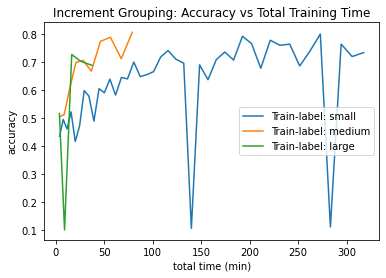

In [139]:
plot_accuracies_multi(comparison_arr, title='Increment Grouping: Accuracy vs Total Training Time')

['small', 'medium', 'large']
[0.6270642786153725, 0.6766599774360657, 0.5458800122141838]


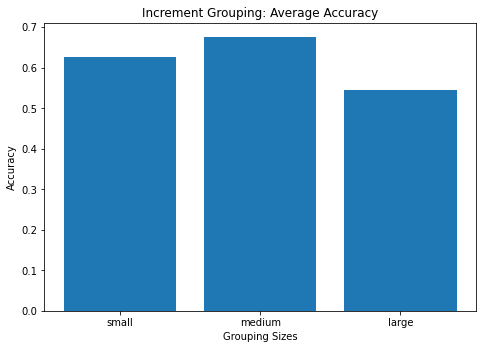

In [140]:
plot_bar(x_label_names, avg_accuracy_arr,
         x_label='Grouping Sizes', y_label='Accuracy',
         title='Increment Grouping: Average Accuracy')

['small', 'medium', 'large']
[317.7, 78.73333333333333, 36.916666666666664]


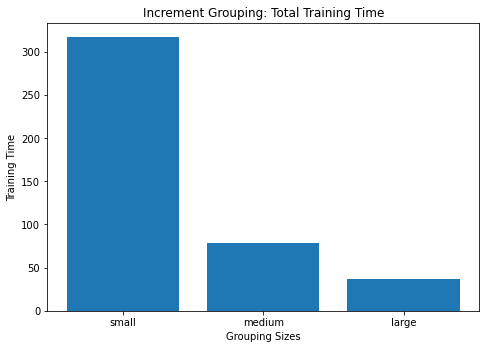

In [120]:
plot_bar(x_label_names, training_times_arr,
         x_label='Grouping Sizes', y_label='Training Time',
         title='Increment Grouping: Total Training Time')

[5.066466243325435, 1.163558300457817, 0.6762780435379246]
['small', 'medium', 'large']
[5.066466243325435, 1.163558300457817, 0.6762780435379246]


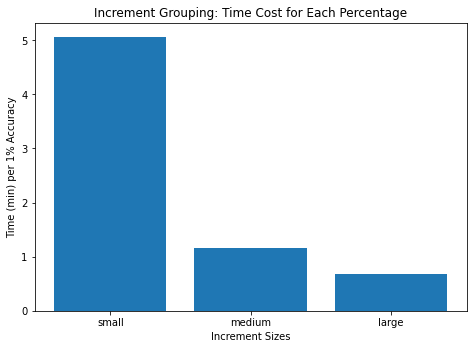

In [135]:
time_spent_for_1_percent_accuracy = [ training_times_arr[x] / (avg_accuracy_arr[x] * 100)
                                     for x in range(0, len(drift_avg_accuracy_arr))]
print(time_spent_for_1_percent_accuracy)
plot_bar(x_label_names, time_spent_for_1_percent_accuracy,
         x_label='Increment Sizes', y_label='Time (min) per 1% Accuracy',
         title='Increment Grouping: Time Cost for Each Percentage')

# Graping Drift Analysis 

In [121]:
def clean_drift_json(drift_json):
    new_dict = {}
    new_training_group_arr = []
    train_size_dict = {}
        
    for group in run_group_dict['training_group']:
        # If its not in the dictionary add it
        if not train_size_dict.get(group['train_size'], None):
            train_size_dict[group['train_size']] = group
        # If it is - compare the len of  the test_results and replace if larger
        else:
            dict_train_size_len = len(train_size_dict[group['train_size']]['test_result'])
            group_train_size_len = len(group['test_result'])
            
            if group_train_size_len > dict_train_size_len:
                train_siz_dict[group['train_size']] = group
                
    for key in train_size_dict.keys():
        new_training_group_arr.append( train_size_dict[key])
        
    drift_json['training_group'] = new_training_group_arr
    return drift_json
            

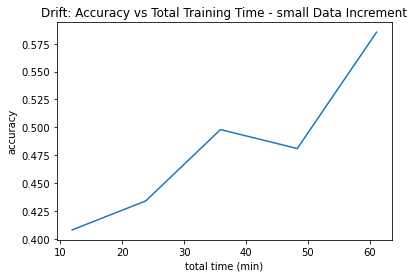

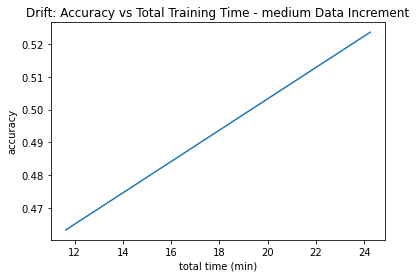

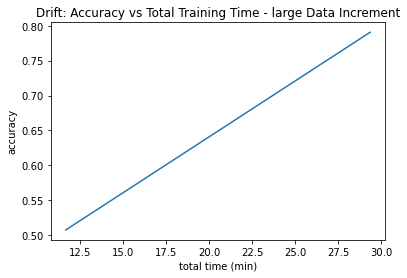

In [122]:
# Load in Data File for Groupings Run
drift_file_names = ['data_small_0_group_drift.txt', 'data_medium_0_group_drift.txt', 'data_large_0_group_drift.txt']
drift_comparison_arr = []
drift_avg_accuracy_arr = []
drift_training_times_arr = []
x_label_names = []
for file_name in drift_file_names:
    with open('result_data/run_0_drift/' + file_name, 'r') as f:
        run_group_dict = json.load(f)
        run_group_dict = clean_drift_json(run_group_dict)
        x_label_names.append(run_group_dict['run_name'].split(' ')[1])
        
        graph_data = []
        total_training_time = 0
        for group in run_group_dict['training_group']:
            group_test_dict = {
                'val_acc': sum([x['val_acc'] for x in group['test_result']]) / len(group['test_result']),
                'val_loss': sum([x['val_loss'] for x in group['test_result']]) / len(group['test_result'])
            }
            total_training_time += group['time_to_train_validate']
            group_test_dict['total_time'] = total_training_time/60
            graph_data.append(group_test_dict)
            
        # Get Total Training Time in Minutes
        drift_training_times_arr.append(total_training_time/60)
        
        # Get Avg Accuracy    
        avg_accuracy = sum([x['val_acc'] for x in graph_data]) / len(graph_data)
        drift_avg_accuracy_arr.append(avg_accuracy)
        
        # Build Line Graph Comparison Dict
        comparison_arr_dict = {
            'line_title': run_group_dict['run_name'],
            'graph_data': graph_data
        }
        drift_comparison_arr.append(comparison_arr_dict)
        
        # Plot accuracy
        plot_accuracies(graph_data, 'Drift: Accuracy vs Total Training Time - {} Data Increment'.format(
            run_group_dict['run_name'].split(' ')[1]))
        

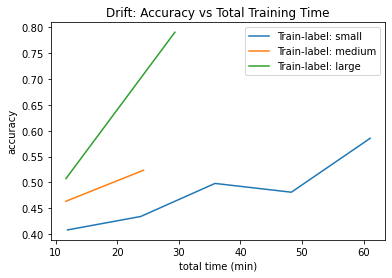

In [123]:
plot_accuracies_multi(drift_comparison_arr, title='Drift: Accuracy vs Total Training Time')

['small', 'medium', 'large']
[0.48126445710659027, 0.49345555239253575, 0.6490249584118526]


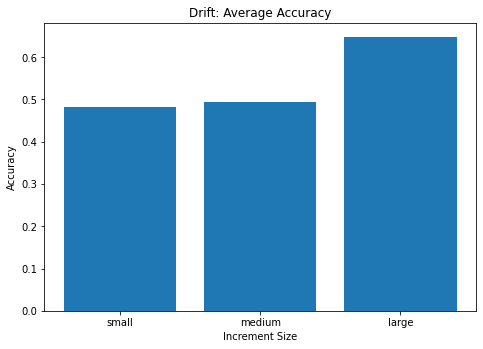

In [125]:
plot_bar(x_label_names, drift_avg_accuracy_arr,
         x_label='Increment Size', y_label='Accuracy',
         title='Drift: Average Accuracy')

['small', 'medium', 'large']
[61.06666666666667, 24.25, 29.35]


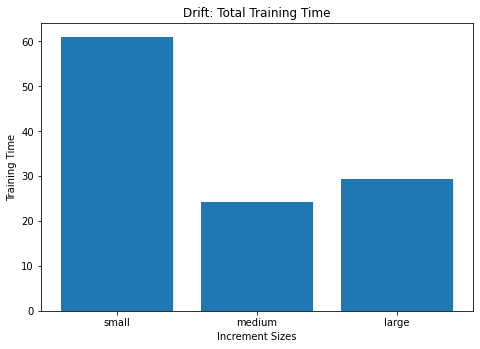

In [126]:
plot_bar(x_label_names, drift_training_times_arr,
         x_label='Increment Sizes', y_label='Training Time',
         title='Drift: Total Training Time')

[1.2688796308334411, 0.49143230595791376, 0.45221681569563515]
['small', 'medium', 'large']
[1.2688796308334411, 0.49143230595791376, 0.45221681569563515]


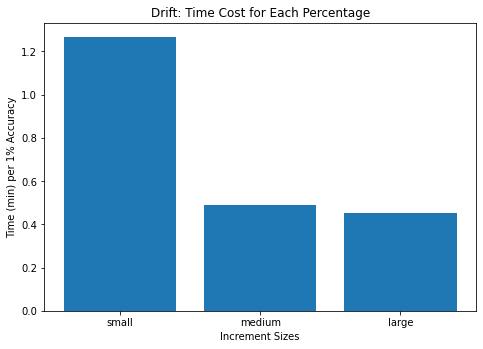

In [134]:

time_spent_for_1_percent_accuracy = [ drift_training_times_arr[x] / (drift_avg_accuracy_arr[x] * 100)
                                     for x in range(0, len(drift_avg_accuracy_arr))]
print(time_spent_for_1_percent_accuracy)
plot_bar(x_label_names, time_spent_for_1_percent_accuracy,
         x_label='Increment Sizes', y_label='Time (min) per 1% Accuracy',
         title='Drift: Time Cost for Each Percentage')

In [136]:
print(x_label_names)
print(drift_training_times_arr)
print(drift_avg_accuracy_arr)
print(time_spent_for_1_percent_accuracy)

['small', 'medium', 'large']
[61.06666666666667, 24.25, 29.35]
[0.48126445710659027, 0.49345555239253575, 0.6490249584118526]
[5.066466243325435, 1.163558300457817, 0.6762780435379246]
